In [20]:
from time import time
import numba as nb
import numexpr as ne
import numpy as np
from matplotlib import pyplot as plt
import blosc2

In [72]:
def run_numba(num_threads, a, b, c):
    nb.set_num_threads(num_threads)  # Set the number of threads for Numba
    @nb.jit(nopython=True, parallel=True, nogil=True)
    def mean_numba(a, b, c):
        out = np.empty(a.shape, a.dtype)  # Create an empty array to store the result
        for i in nb.prange(a.shape[0]):  # Iterate over the first dimension of array a in parallel
            for j in nb.prange(a.shape[1]):  # Iterate over the second dimension of array a in parallel
                out[i, j] = (a[i, j] + b[i, j] * c[i, j]) + 2  # Calculate the corresponding value in the resulting array
        return out  # Return the resulting array

    # Measure the execution time of the approach with Numba
    start = time()  # Initial time
    mean_expr = mean_numba(a, b, c)  # Call the mean_numba function
    t = time() - start  # Calculate elapsed time
    return t

In [73]:
def run_lazy_expr(num_threads, a, b, c, cparams):
    blosc2.set_nthreads(num_threads)  # Set the number of threads for Blosc2 compression
    ne.set_num_threads(num_threads)  # Set the number of threads for NumExpr evaluation
    # Convert NumPy arrays to compressed arrays using Blosc2
    a1 = blosc2.asarray(a, cparams=cparams)  # Compressed array a
    b1 = blosc2.asarray(b, cparams=cparams)  # Compressed array b
    c1 = blosc2.asarray(c, cparams=cparams)  # Compressed array c
    # Perform the mathematical operation using LazyExpr: addition, multiplication, and addition of 2
    expr = a1 + b1 * c1  # LazyExpr expression
    expr += 2  # Add 2
    t = time()  # Initial time
    res = expr.evaluate(cparams=cparams)  # Evaluate the LazyExpr expression and get the result
    tt = time() - t  # Calculate elapsed time
    return tt

In [74]:
def run_NumExpr(num_thread, a, b, c):
    ne.set_num_threads(num_thread)
    t = time()
    d1 = ne.evaluate("a+b*c+2")
    t1 = time() - t 
    return t1

In [77]:
# Main program
# Create NumPy arrays a, b, and c with size 3000x4000 and values generated using linspace
dtype = np.float64  # Data type for the arrays
reshape = [30000, 4000]  # Reshape for arrays
size = reshape[0] * reshape[1]   # Total size of the arrays (30000 * 4000) = 120_000_000
a = np.linspace(0, 10, num=size, dtype=dtype).reshape(reshape)  # Array a
b = np.linspace(0, 10, num=size, dtype=dtype).reshape(reshape)  # Array b
c = np.linspace(0, 10, num=size, dtype=dtype).reshape(reshape)  # Array c
mega_bytes = (size // 8) // 1024 ** 2  # Total megabytes
threads = []  # Number of threads
numba_times = []  # List to store Numba execution speed
lazy_expr_times = []  # List to store LazyExpr speed
numexpr_times = [] # List to store NumExpr execution speed
clevels_LZ4 = [0, 1, 5]  # Compression levels
clevels_ZSTD = [1, 5]  # Compression levels
mean_expr = run_numba(1, a, b, c)  # Call run_numba to warm up Numba and ensure accurate timings
speed = []  # List to store speeds for plotting
# Calculate execution times for Numba
for num_thread in range(1, 33):
    threads.append(num_thread)
    numba = mega_bytes / run_numba(num_thread, a, b, c)
    num_expr = mega_bytes / run_NumExpr(num_thread, a, b, c)
    numba_times.append(numba)
    numexpr_times.append(num_expr)
    speed.append(numba)
    speed.append(num_expr)

# Calculate execution times for LazyExpr

for clevel in clevels_LZ4:
    lazy_expr_times_LZ4 = []
    for num_thread in threads:
        cparams_LZ4 = {"clevel": clevel, "codec": blosc2.Codec.LZ4}  # Compression parameters
        speed_LZ4 = mega_bytes / run_lazy_expr(num_thread, a, b, c, cparams_LZ4)
        lazy_expr_times_LZ4.append(speed_LZ4)
        speed.append(speed_LZ4)
    lazy_expr_times.append(lazy_expr_times_LZ4)
    
for clevel in clevels_ZSTD: 
    lazy_expr_times_ZSTD = []
    for num_thread in threads:
        cparams_ZSTD = {"clevel": clevel, "codec": blosc2.Codec.ZSTD}
        speed_ZSTD = mega_bytes / run_lazy_expr(num_thread, a, b, c, cparams_ZSTD)
        lazy_expr_times_ZSTD.append(speed_ZSTD)
        speed.append(speed_ZSTD)
    lazy_expr_times.append(lazy_expr_times_ZSTD)

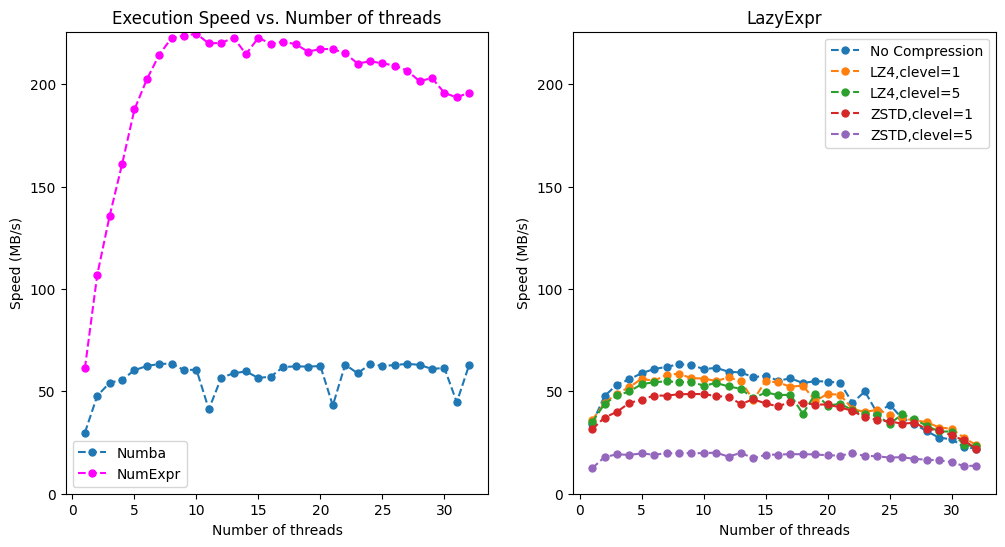

In [78]:
# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
limit_y = max(speed) + 1  # Limit for y-axis

# Graph Numba
ax1.plot(threads, numba_times, marker='o', markersize=5, linestyle='--', label='Numba')  # Plot Numba data
ax1.plot(threads, numexpr_times, marker='o', markersize=5, linestyle='--', color='magenta', label='NumExpr')  # Plot NumExpr data
ax1.set_xlabel('Number of threads')  # Set x-axis label
ax1.set_ylabel('Speed (MB/s)')  # Set y-axis label
ax1.set_title('Execution Speed vs. Number of threads')  # Set title
ax1.legend()  # Add legend
ax1.set_ylim(0, limit_y)  # Set y-axis limit

# Graph LazyExpr
i = 0
ax2.plot(threads, lazy_expr_times[i], marker='o', markersize=5, linestyle='--', label=f"No Compression")  # Plot LazyExpr data
i = 1
for j in range(len(clevels_LZ4)-1):
    ax2.plot(threads, lazy_expr_times[i], marker='o', markersize=5, linestyle='--', label=f"LZ4,clevel={clevels_LZ4[j+1]}")  # Plot LazyExpr data
    i += 1
for clevel in clevels_ZSTD:
    ax2.plot(threads, lazy_expr_times[i], marker='o', markersize=5, linestyle='--', label=f"ZSTD,clevel={clevel}")  # Plot LazyExpr data
    i += 1
ax2.set_xlabel('Number of threads')  # Set x-axis label
ax2.set_ylabel('Speed (MB/s)')  # Set y-axis label
ax2.set_title('LazyExpr')  # Set title
ax2.legend()  # Add legend
ax2.set_ylim(0, limit_y)  # Set y-axis limit
plt.show()  # Show the plot
